In [1]:

import os

from config import BASE_DIR

domain = "bible"
exp_name = "gvae_init"
BASELINE_DIR = f"{BASE_DIR}/experiments/{domain}/baselines"
BASELINE_GNN_DIR = f"{BASE_DIR}/experiments/{domain}/gnn/{exp_name}"


In [2]:



def list_files(dir):
    filenames = []
    for root, dirs, files in os.walk(dir):
        for file in files:
            filenames.append(file)
    return filenames


print(list_files(BASELINE_DIR))
print(list_files(BASELINE_GNN_DIR))

['book_unsupervised.csv', 'book_supervised.csv']
['gvae_init_book_1_adj_types.csv']


In [3]:
task_by_domain = {"dss": ["book", "composition", "section"], "bible": ["book"]}
tasks = task_by_domain[domain]

gnn_name_fomrat = "{}_{}_1_adj_types.csv"

COMPARISON_SCHEME = ["task", "vectorizer", "model", "silhouette", "clustering_accuracy", "jaccard", "dasgupta",
                     "hidden_dim", "adj_type"]

compare_list = {
    task: [
        f"{BASELINE_DIR}/{task}_unsupervised.csv",
        f"{BASELINE_GNN_DIR}/{gnn_name_fomrat.format(exp_name, task)}"
    ]
    for task in tasks
}

In [4]:

def generate_all_results(compare_list, tasks, main_metric):
    results = []
    for task in tasks:
        baseline = pd.read_csv(compare_list[task][0])
        baseline["task"] = task
        baseline["adj_type"] = None
        baseline["hidden_dim"] = None
        baseline["model"] = "Only Embeddings"
        baseline = baseline.rename(columns={"vectorizer_type": "vectorizer"})
        results.append(baseline[COMPARISON_SCHEME].to_dict(orient="records"))

        gnn = pd.read_csv(compare_list[task][1])
        gnn = gnn.rename(columns={"bert_model": "vectorizer_type"})
        gnn["model"] = "GVAE"
        gnn["task"] = task
        gnn = gnn.rename(columns={"vectorizer_type": "vectorizer"})
        max_idx = gnn.groupby('vectorizer')[main_metric].idxmax()

        max_test_acc_rows = gnn.loc[max_idx]
        max_test_acc_rows["model"] = "GVAE"
        max_test_acc_rows["task"] = task
        results.append(max_test_acc_rows[COMPARISON_SCHEME].to_dict(orient="records"))

    all_results = pd.DataFrame([item for sublist in results for item in sublist])
    all_results = all_results.sort_values(by=main_metric, ascending=False)
    return all_results


In [5]:

def get_group_by_vectorizer(i):
    if "yonatanlou" in i:
        return 'fine_tuned'
    elif "dicta" in i or "onlplab" in i:
        return 'pre_trained_bert'
    else:
        return 'classic_text_features'


def generate_color_map(df, col, group_name, base_color="PuOr", base_color_by_group=None):
    groups = df.groupby(group_name)[col].apply(list).to_dict()
    num_groups = df[col].nunique()
    all_colors = list(sns.color_palette(base_color, num_groups))
    color_map = {}
    i = 0
    if not base_color_by_group:
        for group, items in groups.items():
            items = list(set(items))

            for item in items:
                color_map[item] = all_colors[i]
                i += 1
        return color_map

    # Function to generate shades of a base color
    def generate_shades(base_color, num_shades):
        # return sns.hls_palette(num_shades, h=base_color, l=0.5, s=0.5)

        return sns.color_palette(base_color, n_colors=num_shades + 1)

    # Create the color map
    color_map = {}
    for group, items in groups.items():
        shades = generate_shades(base_color_by_group[group], len(items))
        for item, shade in zip(items, shades):
            color_map[item] = shade
    return color_map





In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


def generate_bar_plot(all_results, x_col, y_col, hue_col, vectorizer_type_col, color_map, filename,
                      which_hue_cols=False, base_color_by_group=None):
    # Create a figure and a set of subplots
    fig, axes = plt.subplots(nrows=len(all_results['task'].unique()), ncols=1,
                             figsize=(12, 6 * len(all_results['task'].unique())), sharey=False)
    all_results['task'] = all_results['task'].replace("section", "sectarian")

    # Create a custom order based on base_color_by_group
    if base_color_by_group:
        custom_order = []
        for group in base_color_by_group.keys():
            group_items = all_results[all_results['vectorizer_type'] == group][hue_col].unique()
            custom_order.extend(group_items)
    else:
        custom_order = None

    # Generate colors for each group
    if base_color_by_group:
        group_colors = {}
        for group, cmap_name in base_color_by_group.items():
            cmap = plt.get_cmap(cmap_name)
            group_colors[group] = cmap(0.6)  # Use a specific point in the colormap

    for i, task in enumerate(all_results['task'].unique()):
        # Filter data for the current task
        task_data = all_results[all_results['task'] == task]
        if which_hue_cols is not None:
            task_data = task_data[task_data[hue_col].isin(which_hue_cols)]

        # Sort the data according to the custom order
        if custom_order:
            task_data[hue_col] = pd.Categorical(task_data[hue_col], categories=custom_order, ordered=True)
            task_data = task_data.sort_values(hue_col)

        # Create the plot with sorted bars
        ax = axes[i] if len(all_results['task'].unique()) > 1 else axes
        sns.barplot(ax=ax, x=x_col, y=y_col, hue=hue_col, data=task_data, palette=color_map, hue_order=custom_order)
        ax.set_title(f'{y_col} by {hue_col} for {task} (best by {y_col})', fontsize=16)

        # Adjusting the y-axis limits
        min_y_col = task_data[y_col].min()
        max_y_col = task_data[y_col].max()
        padding = (max_y_col - min_y_col) * 0.1
        ax.set_ylim(min_y_col - padding, max_y_col + padding)

        ax.set_xlabel('Model', fontsize=14)
        ax.set_ylabel(y_col, fontsize=14)
        ax.tick_params(axis='x', rotation=45)

        # Customize legend
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, title='Vectorizer', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        ax.grid(alpha=0.5)

    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    plt.show()

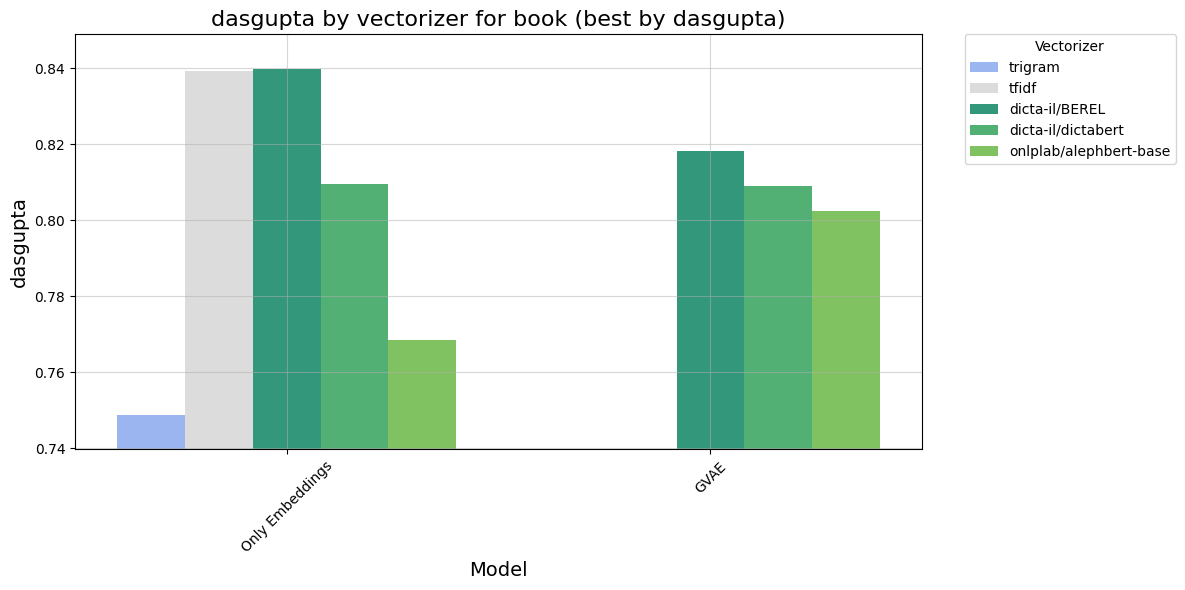

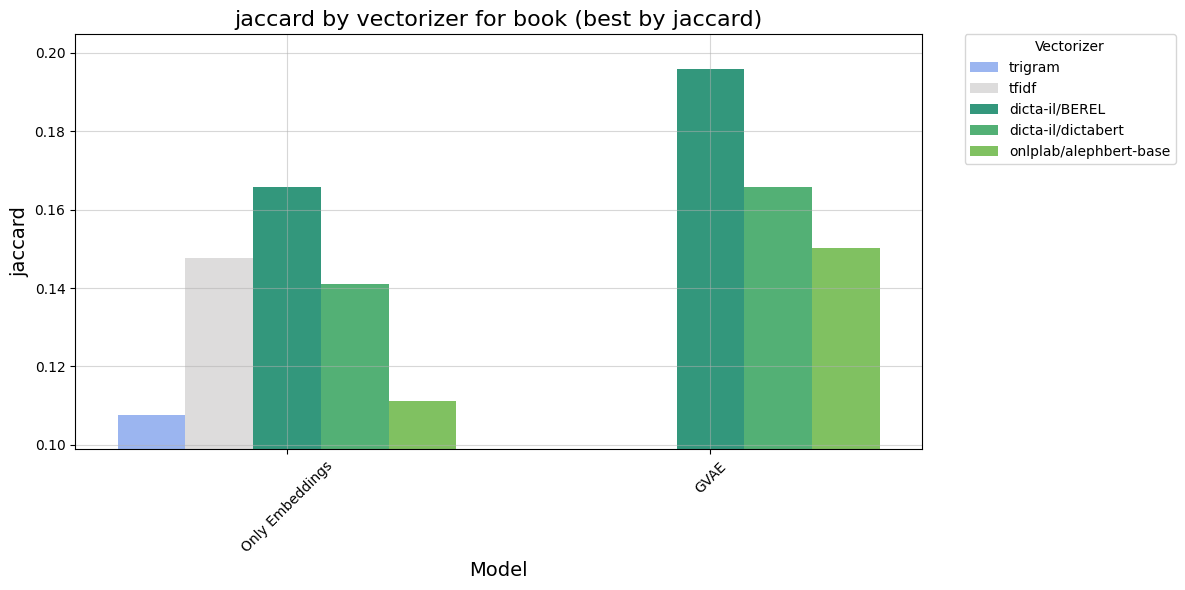

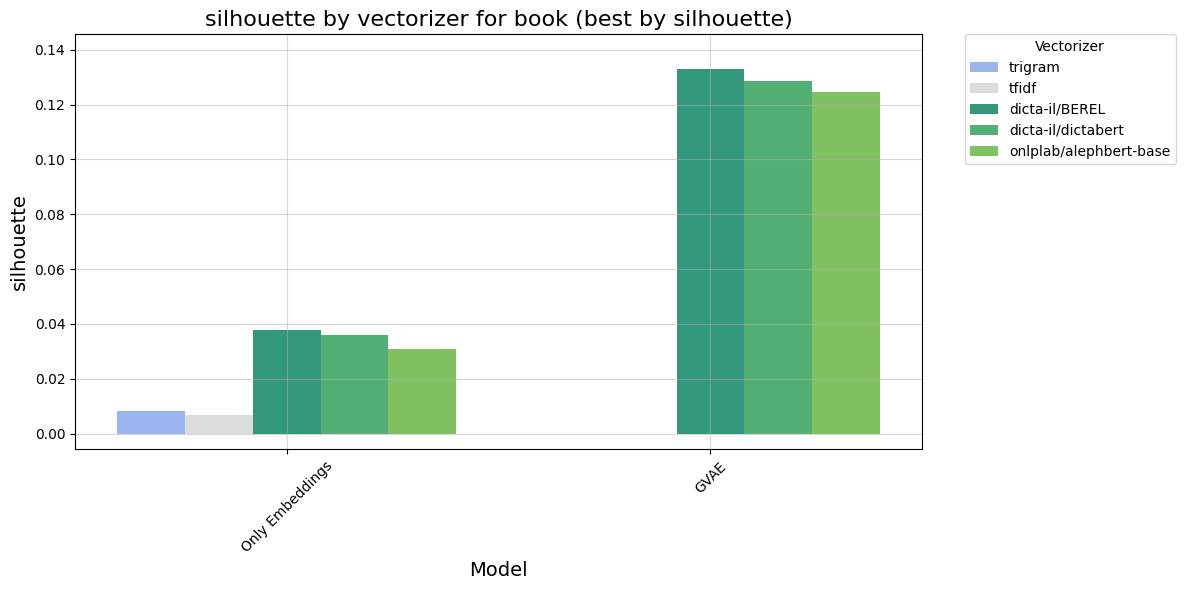

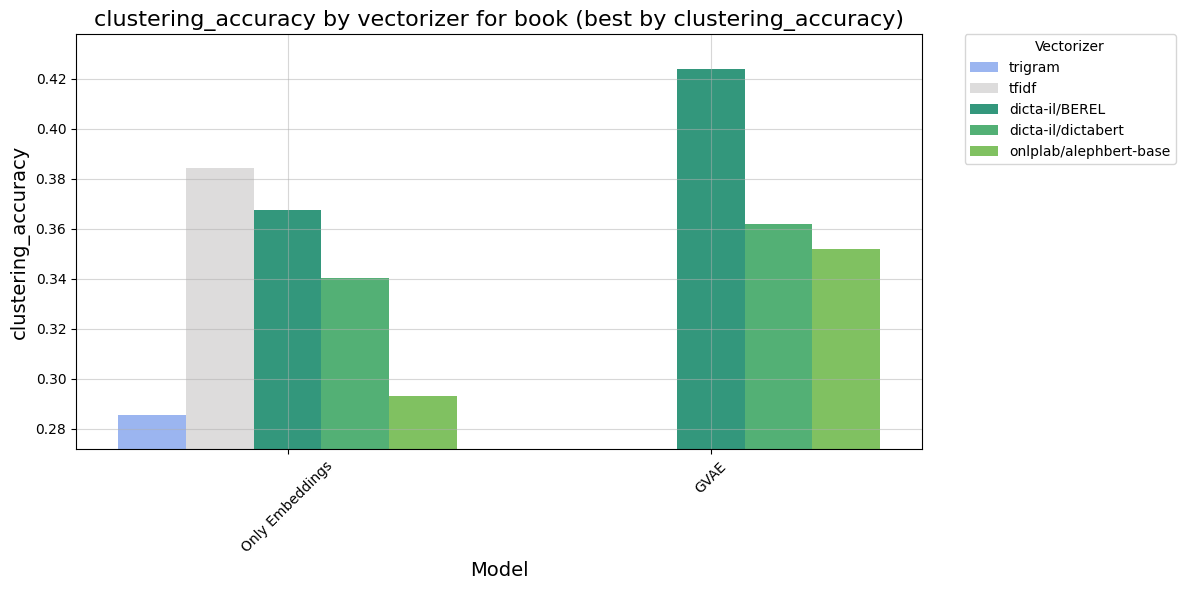

In [7]:
base_color_by_group = {
    'classic_text_features': "coolwarm",  # Red
    'pre_trained_bert': "viridis",  # Green
    'fine_tuned': "Spectral"  # Blue
}

file_name = f"{BASE_DIR}/experiments/dss/gnn/comparsion_plot_all_tasks.png"
file_name = None
# hue_cols = list(all_results[all_results["model"]=="GCN"]["vectorizer"].unique())+["trigram"]


for main_metric in ["dasgupta", "jaccard", "silhouette", "clustering_accuracy", ]:
    all_results = generate_all_results(compare_list, tasks, "silhouette")
    all_results["vectorizer_type"] = all_results["vectorizer"].apply(get_group_by_vectorizer)
    color_map = generate_color_map(all_results, "vectorizer", "vectorizer_type", "RdYlGn", base_color_by_group)
    hue_cols = all_results["vectorizer"].unique()
    all_results = all_results[all_results["vectorizer"] != "dicta-il/MsBERT"]
    plot_obj = generate_bar_plot(all_results, "model", main_metric, "vectorizer", "vectorizer_type", color_map,
                                 filename=file_name, which_hue_cols=hue_cols, base_color_by_group=base_color_by_group)

In [ ]:

results_gnn = []
for task in [tasks[0]]:
    gnn = pd.read_csv(compare_list[task][1])
    gnn = gnn.rename(columns={"bert_model": "vectorizer"})

    gnn["model"] = "GVAE"
    gnn["task"] = task

    results_gnn.append(gnn.to_dict(orient="records"))

all_results_gnn = pd.DataFrame([item for sublist in results_gnn for item in sublist])
all_results_gnn

In [54]:

results_gnn = []
for task in tasks:
    gnn = pd.read_csv(compare_list[task][1])
    gnn = gnn.rename(columns={"bert_model": "vectorizer"})

    gnn["model"] = "GVAE"
    gnn["task"] = task

    results_gnn.append(gnn.to_dict(orient="records"))

all_results_gnn = pd.DataFrame([item for sublist in results_gnn for item in sublist])

MAIN_METRIC = "dasgupta"
all_results_gnn[all_results_gnn["model"] == "GVAE"].sort_values(by=MAIN_METRIC, ascending=False).groupby("task").head(
    2).sort_values(by="vectorizer")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/yonatanlou/dev/QumranNLP/experiments/bible/gnn/gvae_hm_opt/gvae_hm_opt_book_1_adj_types.csv'

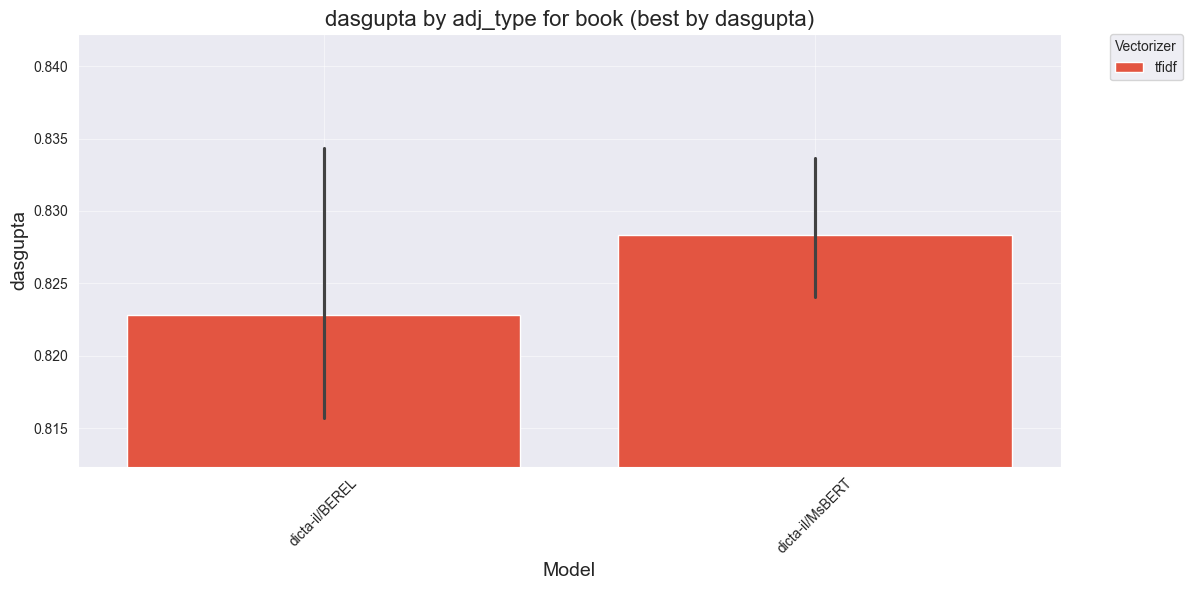

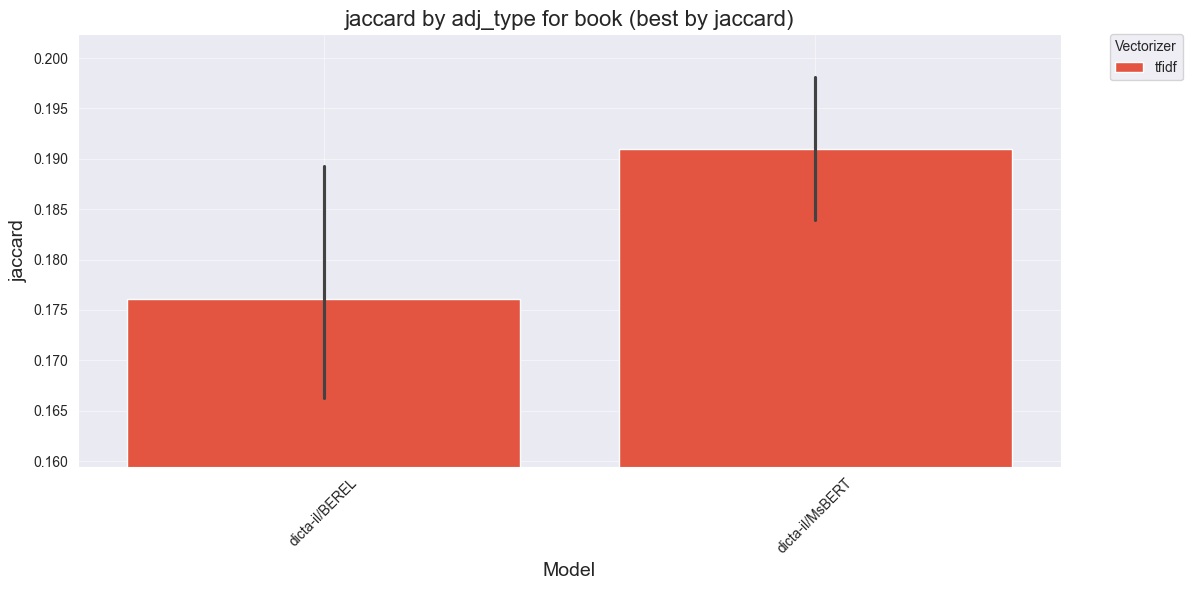

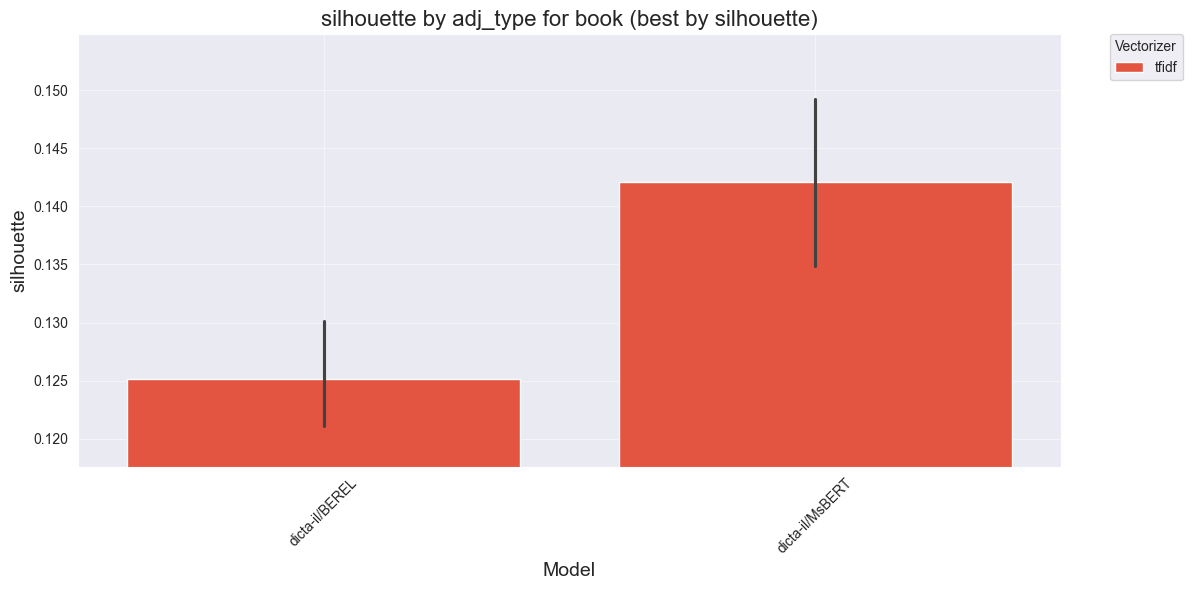

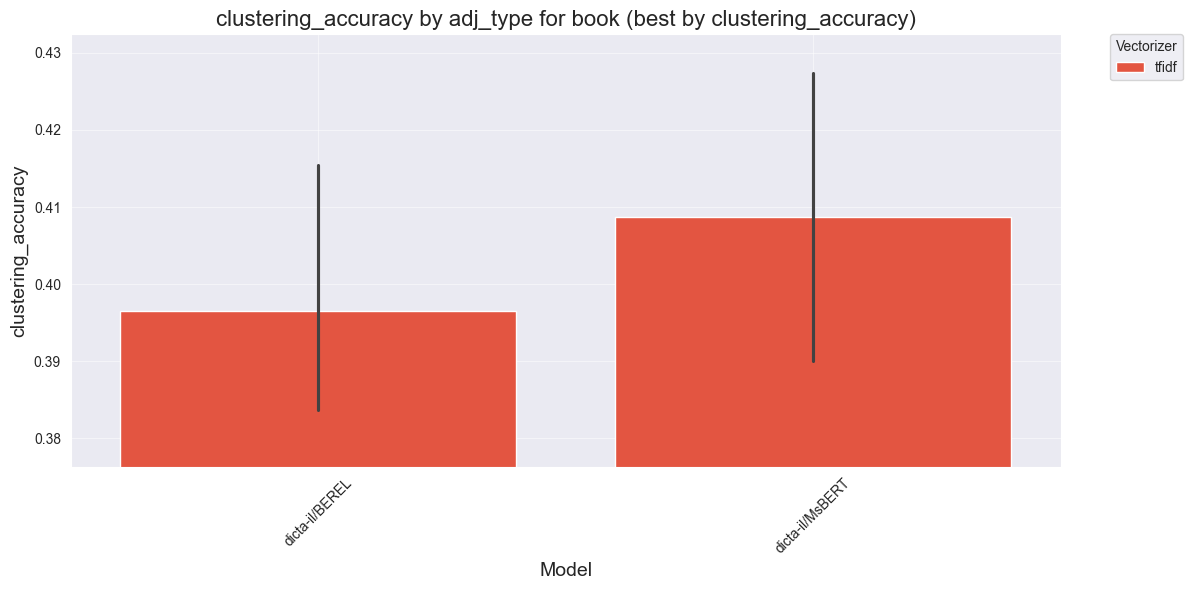

In [55]:
adj_types = all_results_gnn['adj_type'].unique()
palette = sns.color_palette("CMRmap", len(adj_types))
color_dict = dict(zip(adj_types, palette))
# file_name = f"{BASE_DIR}/experiments/dss/gnn/comparsion_plot_all_tasks_different_adj.png"
file_name = None
for metric in ["dasgupta", "jaccard", "silhouette", "clustering_accuracy", ]:
    generate_bar_plot(all_results_gnn, "vectorizer", metric, "adj_type", "num_adjs", color_dict, filename=file_name,
                      which_hue_cols=None)